# Overview for param set 3
This params set deals with the effect of the asymmetry of $\gamma_1$ and $\gamma_2$.

First the acf/ccfs is analyzed when both $\gamma$ parameters are the same.
Later it is analyzed what happens if they are different

In [10]:
import os
from main_multiple_runs import R, T, T_cycles, NoiseType
from plotting.plotting import plot_with_percentiles, plot_fwahh, fwahh
from pathlib import Path
from file_handling import load_ensemble
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 20
plt.rcParams["figure.figsize"] = fig_size

base_path = Path('../../results/params_asymetric_increasing_gammas_1000_500_0')
img_path = base_path / '.images'
os.makedirs(img_path, exist_ok=True)

results, steps, steps_tau1, steps_tau2, steps_gamma1, steps_gamma2, ensembles, R = load_ensemble(base_path)
steps_len = len(steps_gamma1)

# OU Sample
A sample run from both Ornstein Uhlenbeck processes for debug purposes

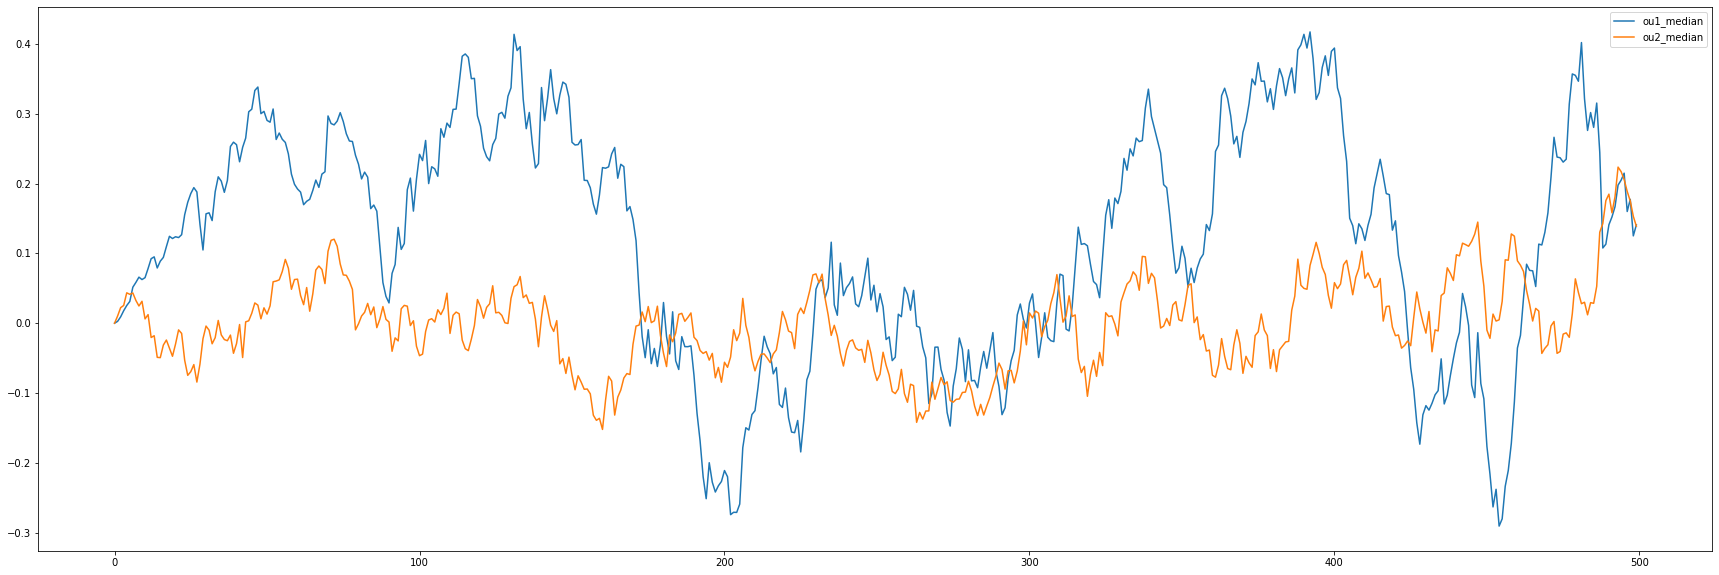

In [2]:
results[0]['ensemble'].filter(like='median').filter(like='ou').plot()

# ACF
Ensemble of autocorrelation functions

## White Noise

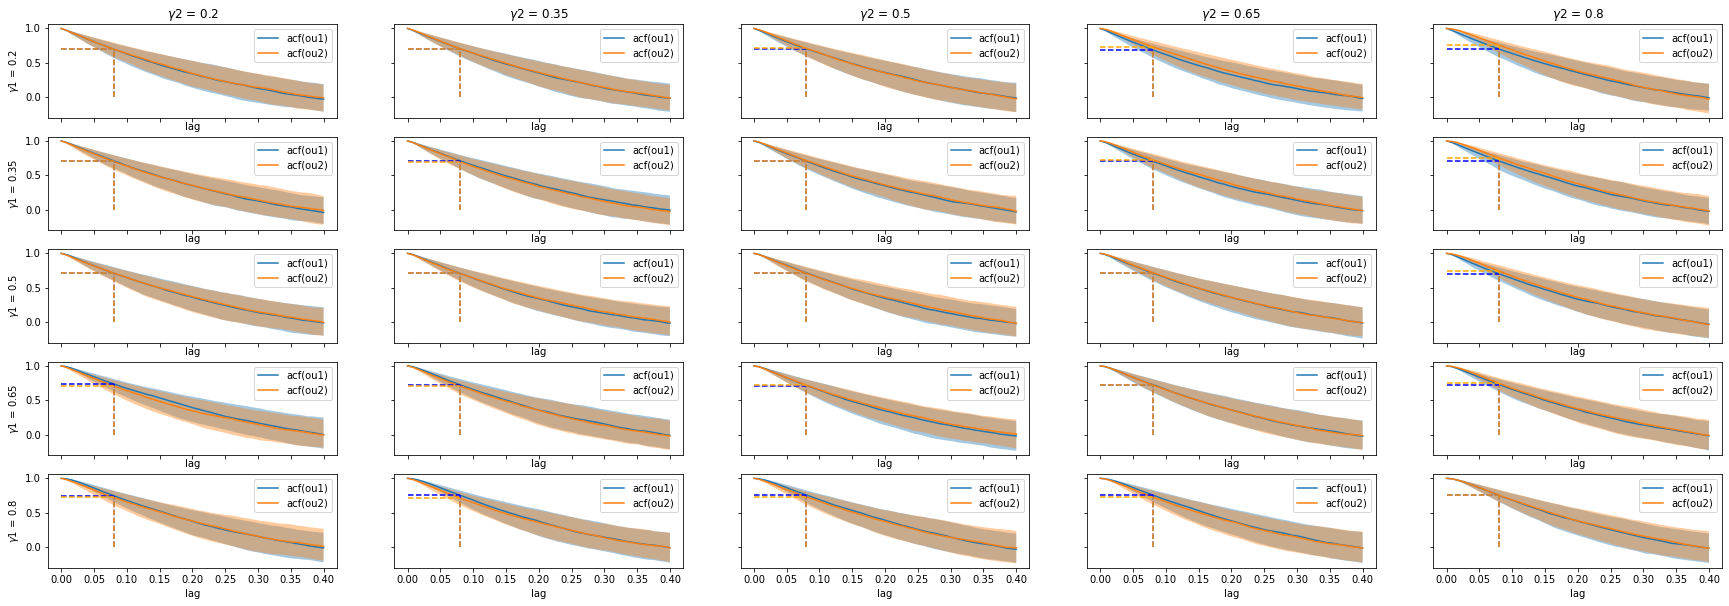

In [3]:

fig, axs = plt.subplots(steps_len - 2, steps_len - 2, sharey=True, sharex=True)
labels = ['ou1', 'ou2']
xlabel = 'lag'
ylabel = 'acf'

for i, gamma in enumerate(steps_gamma1[1:-1]):
    for j, e in enumerate(steps_gamma2[1:-1]):
        res = [res for res in results if res['p']['noiseType']['type'] == NoiseType.RED and res['p']['noiseType']['gamma1'] == gamma and res['p']['noiseType']['gamma2'] == e][0]
        median = res['acf_ensemble']['acf_ou1_median']
        
        plot_with_percentiles(res['acf_ensemble'], axs[i][j], 'acf(ou1)', prefix='acf_ou1_')
        plot_with_percentiles(res['acf_ensemble'], axs[i][j], 'acf(ou2)', prefix='acf_ou2_')
        
        axs[i][j].set_xlabel(xlabel)
        
        for lag in [median.index[round(len(median.index) * 0.2)]]:
            y_ou1 = median[lag]
            y_ou2 = res['acf_ensemble']['acf_ou2_median'][lag]

            axs[i][j].plot([lag, lag], [0, y_ou1], color='blue', linestyle='--')
            axs[i][j].plot([lag, lag], [0, y_ou2], color='orange', linestyle='--')

            axs[i][j].plot([0, lag], [y_ou1, y_ou1], color='blue', linestyle='--')
            axs[i][j].plot([0, lag], [y_ou2, y_ou2], color='orange', linestyle='--')
        
        if i == 0:
            axs[i][j].set_title(f"$\gamma2$ = {e:.2}")
        if j == 0:
#             fig.annotate(f"$\gamma$ = {gamma}", [0, 1])
            axs[i][j].set_ylabel(f"$\gamma1$ = {gamma:.2}")
        
# fig.suptitle('estimated acf from ensemble simulation')
# fig.tight_layout()


# CCF
Ensemble of cross correlation functions for each parameter set.
The red line indicates the full width at half height of the peak.

## White Noise
By looking at the ccf figure it becomes apparent, that $\gamma_1$ controls the cross correlation for lags < T and $\gamma_2$ for lags > T

This can be explained qualitatively by 

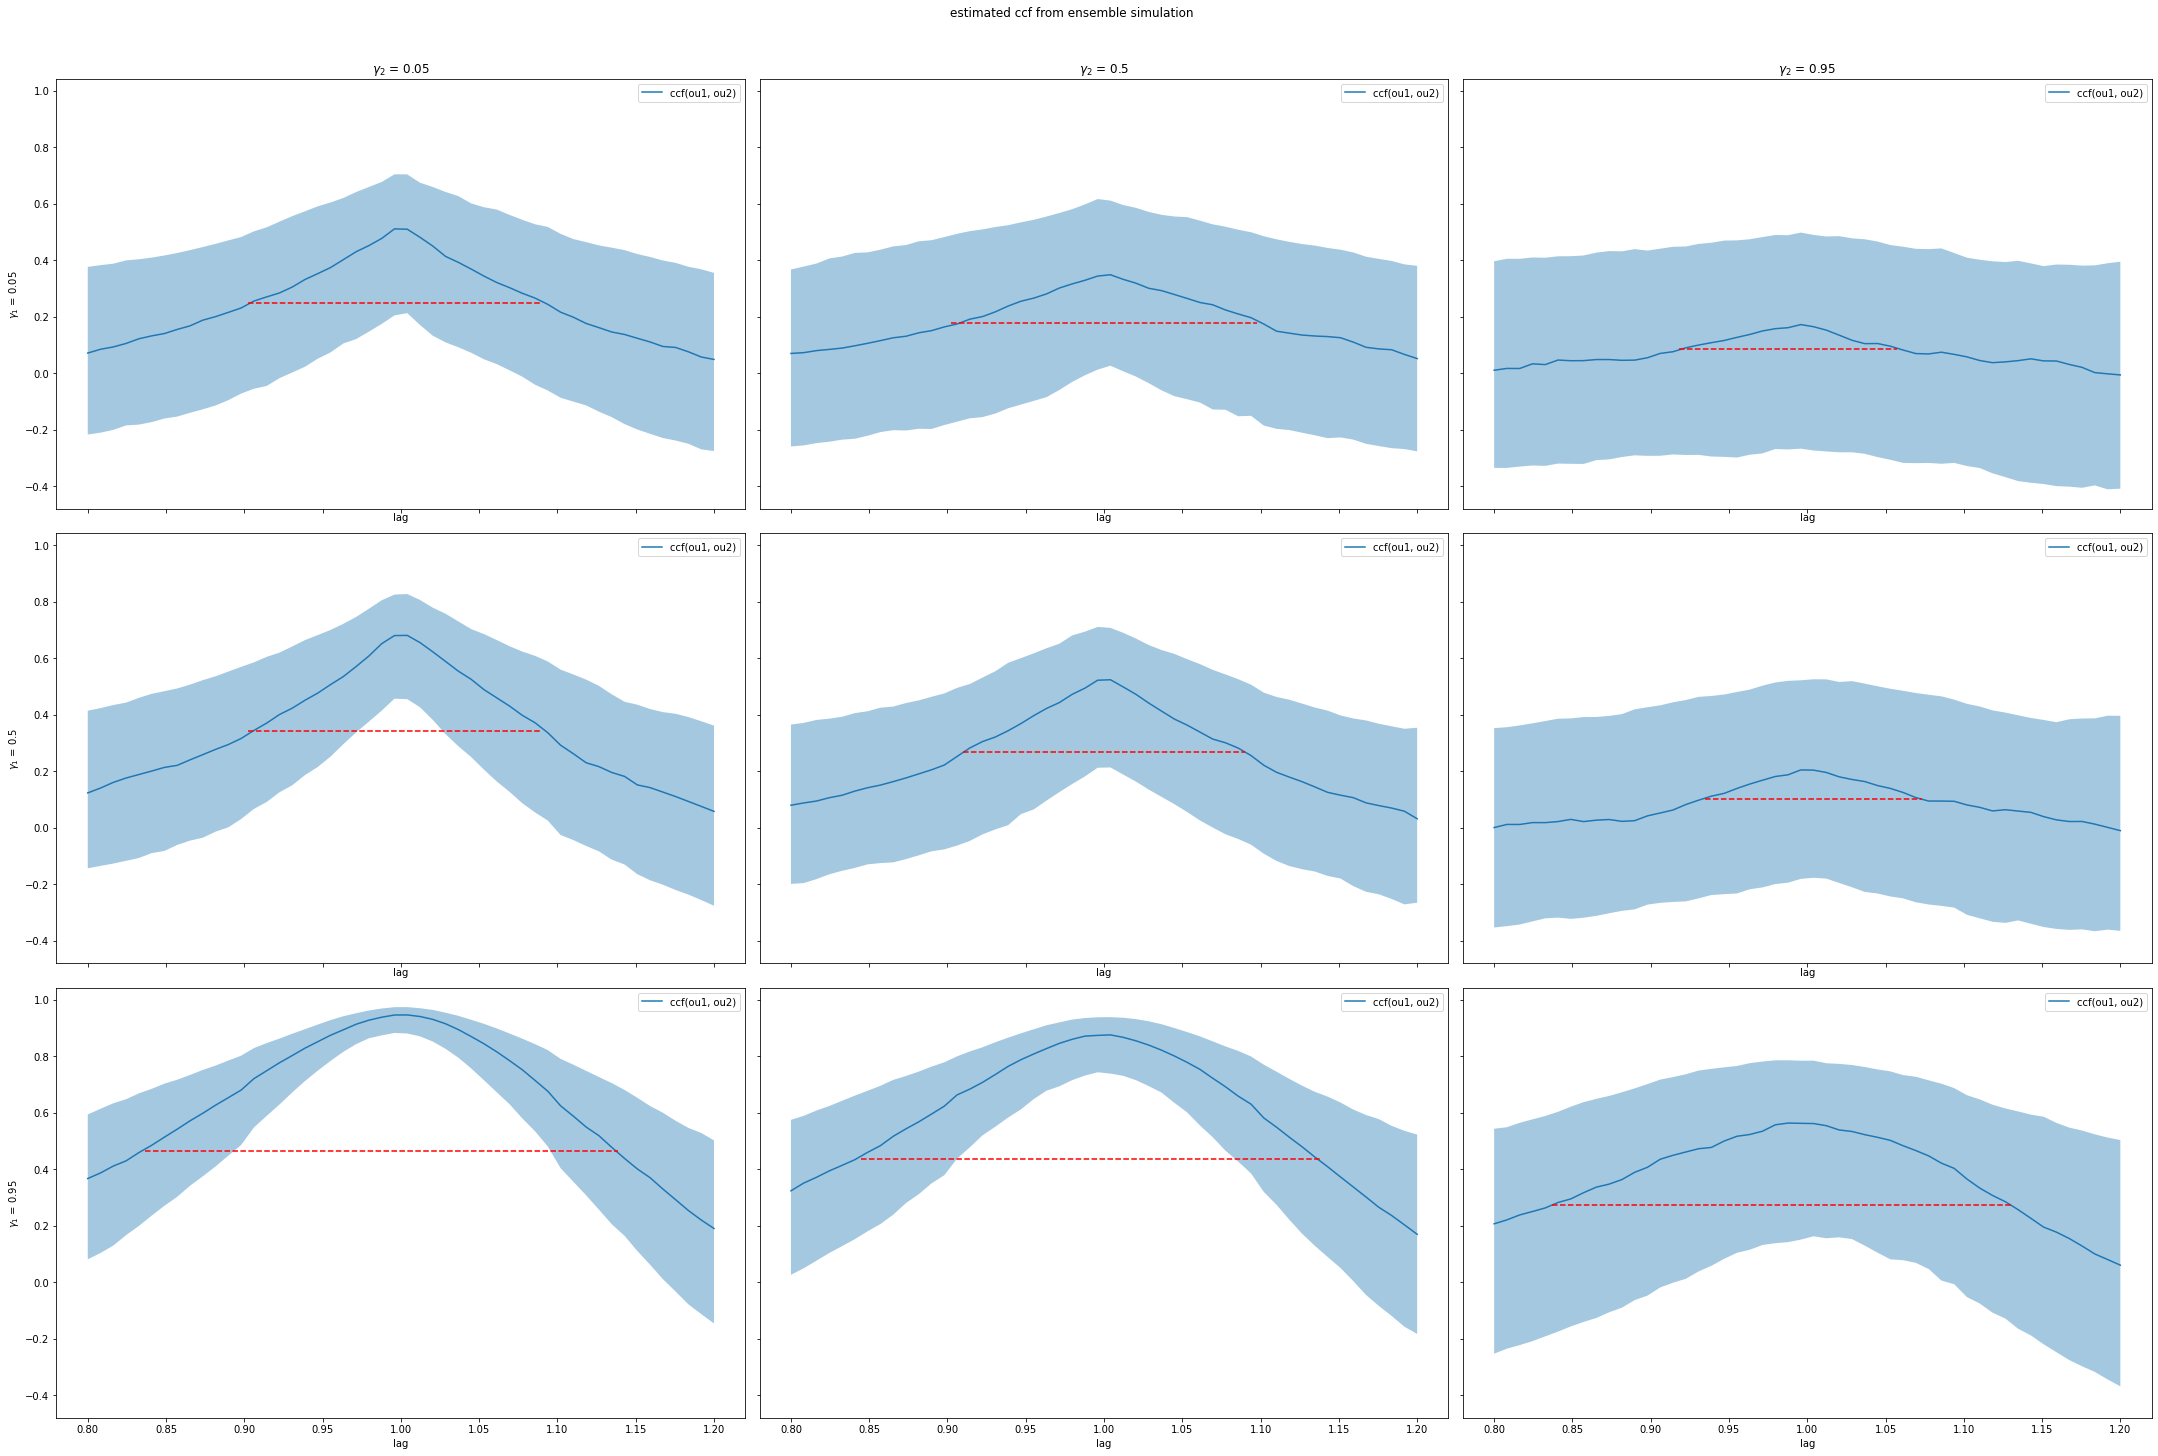

In [11]:
fig, axs = plt.subplots(3, 3, sharey=True, sharex=True)
labels = ['ou1', 'ou2']
xlabel = 'lag'
ylabel = 'acf'

for i, gamma1 in enumerate([steps_gamma1[0], steps_gamma1[int(len(steps_gamma1) / 2)], steps_gamma1[-1]]):
    for j, gamma2 in enumerate([steps_gamma2[0], steps_gamma2[int(len(steps_gamma2) / 2)], steps_gamma2[-1]]):

        res = [res for res in results if res['p']['noiseType']['type'] == NoiseType.RED and res['p']['noiseType']['gamma1'] == gamma1 and res['p']['noiseType']['gamma2'] == gamma2][0]
        median = res['ccf_ensemble']['ccf_median']
        
        plot_with_percentiles(res['ccf_ensemble'], axs[i][j], 'ccf(ou1, ou2)', prefix='ccf_')
        
        axs[i][j].set_xlabel(xlabel)
        
        plot_fwahh(axs[i][j], median)
        
        if i == 0:
            axs[i][j].set_title(f"$\\gamma_2$ = {gamma2:.2}")
        if j == 0:
#             fig.annotate(f"$\gamma$ = {gamma}", [0, 1])
            axs[i][j].set_ylabel(f"$\\gamma_1$ = {gamma1:.2}")
        
fig.suptitle('estimated ccf from ensemble simulation')
fig.tight_layout()
fig.subplots_adjust(0.03, 0, 1, 0.93)
plt.savefig(img_path / 'ccf.pdf', format='pdf')

# Correlation Analysis



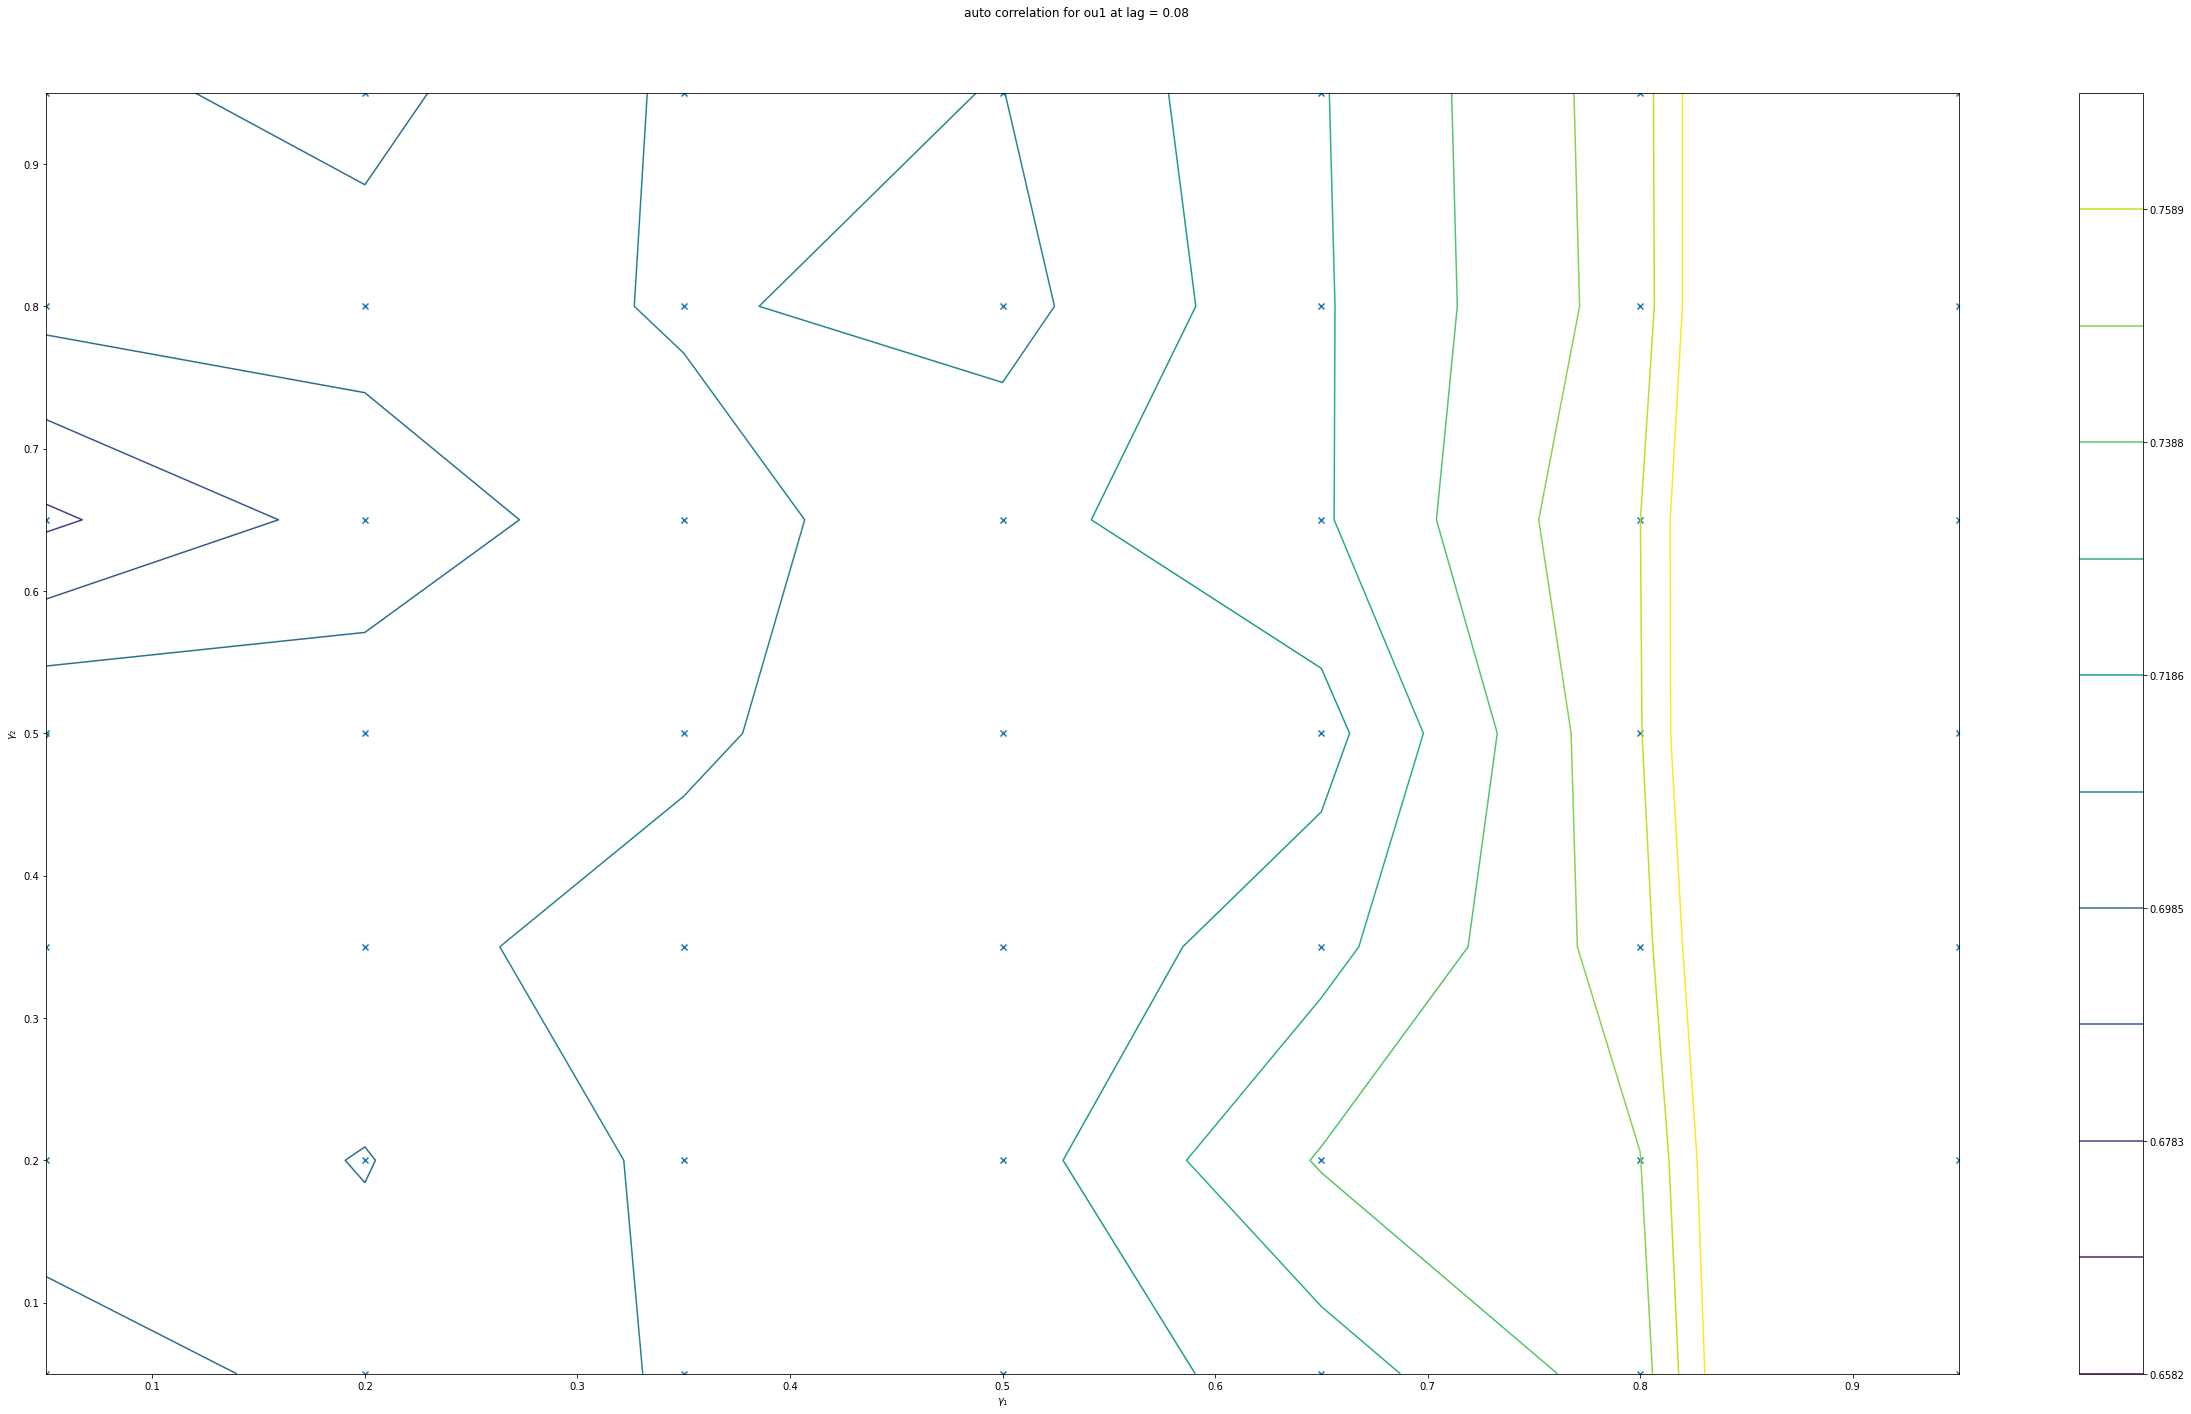

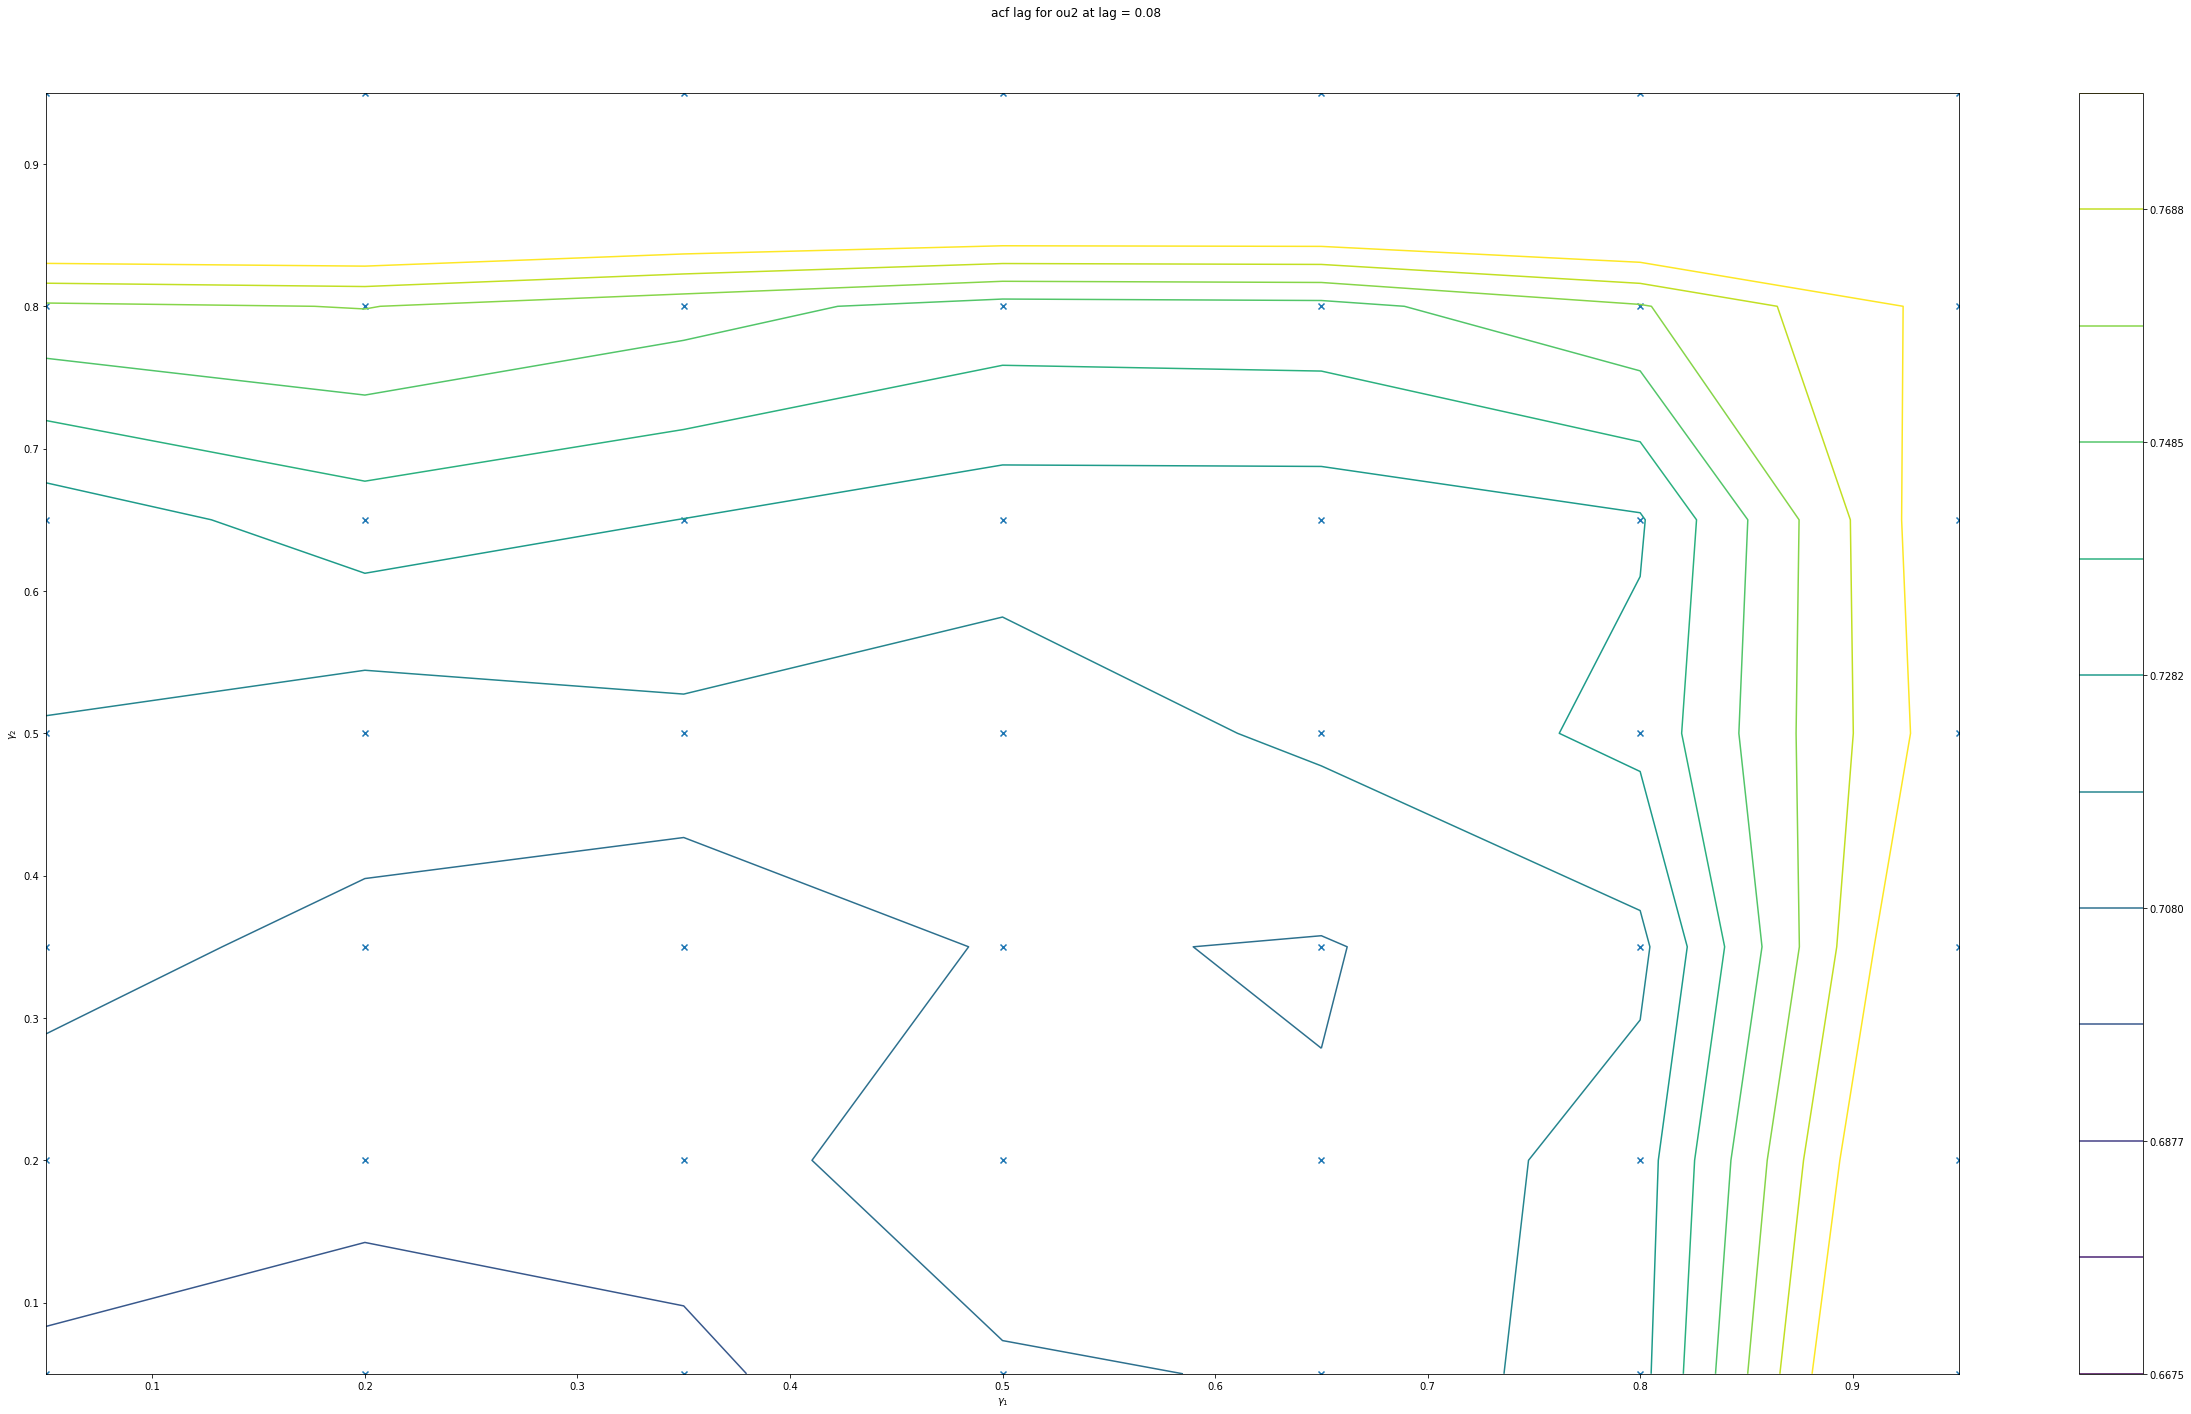

In [12]:
from plotting.plotting import plt_correlation
import numpy as np

lag = results[0]['acf_ensemble']['acf_ou1_median'].index[round(len(median.index) * 0.2)]

plt_correlation(results, 
                steps_gamma1, 
                steps_gamma2, 
                yFn=lambda r: r['acf_ensemble']['acf_ou1_median'].iloc[round(len(r['acf_ensemble']['acf_ou1_median'].index) * 0.2)],
                get_x=lambda p: p['noiseType']['gamma1'],
                get_y=lambda p: p['noiseType']['gamma2'],
                ylabel = '$\\gamma_2$',
                xlabel= '$\\gamma_1$',
                noise_type=NoiseType.RED,
                title=f'auto correlation for ou1 at lag = {lag:.2}',
                hide_label=True,
                plt_red=False)

plt.tight_layout()
plt.subplots_adjust(None, None, 1.13, 0.92)
plt.savefig(img_path / 'acf_correlation_ou1.pdf', format='pdf')

plt_correlation(results, 
                steps_gamma1, 
                steps_gamma2, 
                yFn=lambda r: r['acf_ensemble']['acf_ou2_median'].iloc[round(len(r['acf_ensemble']['acf_ou2_median'].index) * 0.2)],
                get_x=lambda p: p['noiseType']['gamma1'],
                get_y=lambda p: p['noiseType']['gamma2'],
                noise_type=NoiseType.RED,
                ylabel = '$\\gamma_2$',
                xlabel= '$\\gamma_1$',
                title=f'acf lag for ou2 at lag = {lag:.2}',
                hide_label=True,
                plt_red=False)

plt.tight_layout()
plt.subplots_adjust(None, None, 1.13, 0.92)
plt.savefig(img_path / 'acf_correlation_ou2.pdf', format='pdf')
# peak height

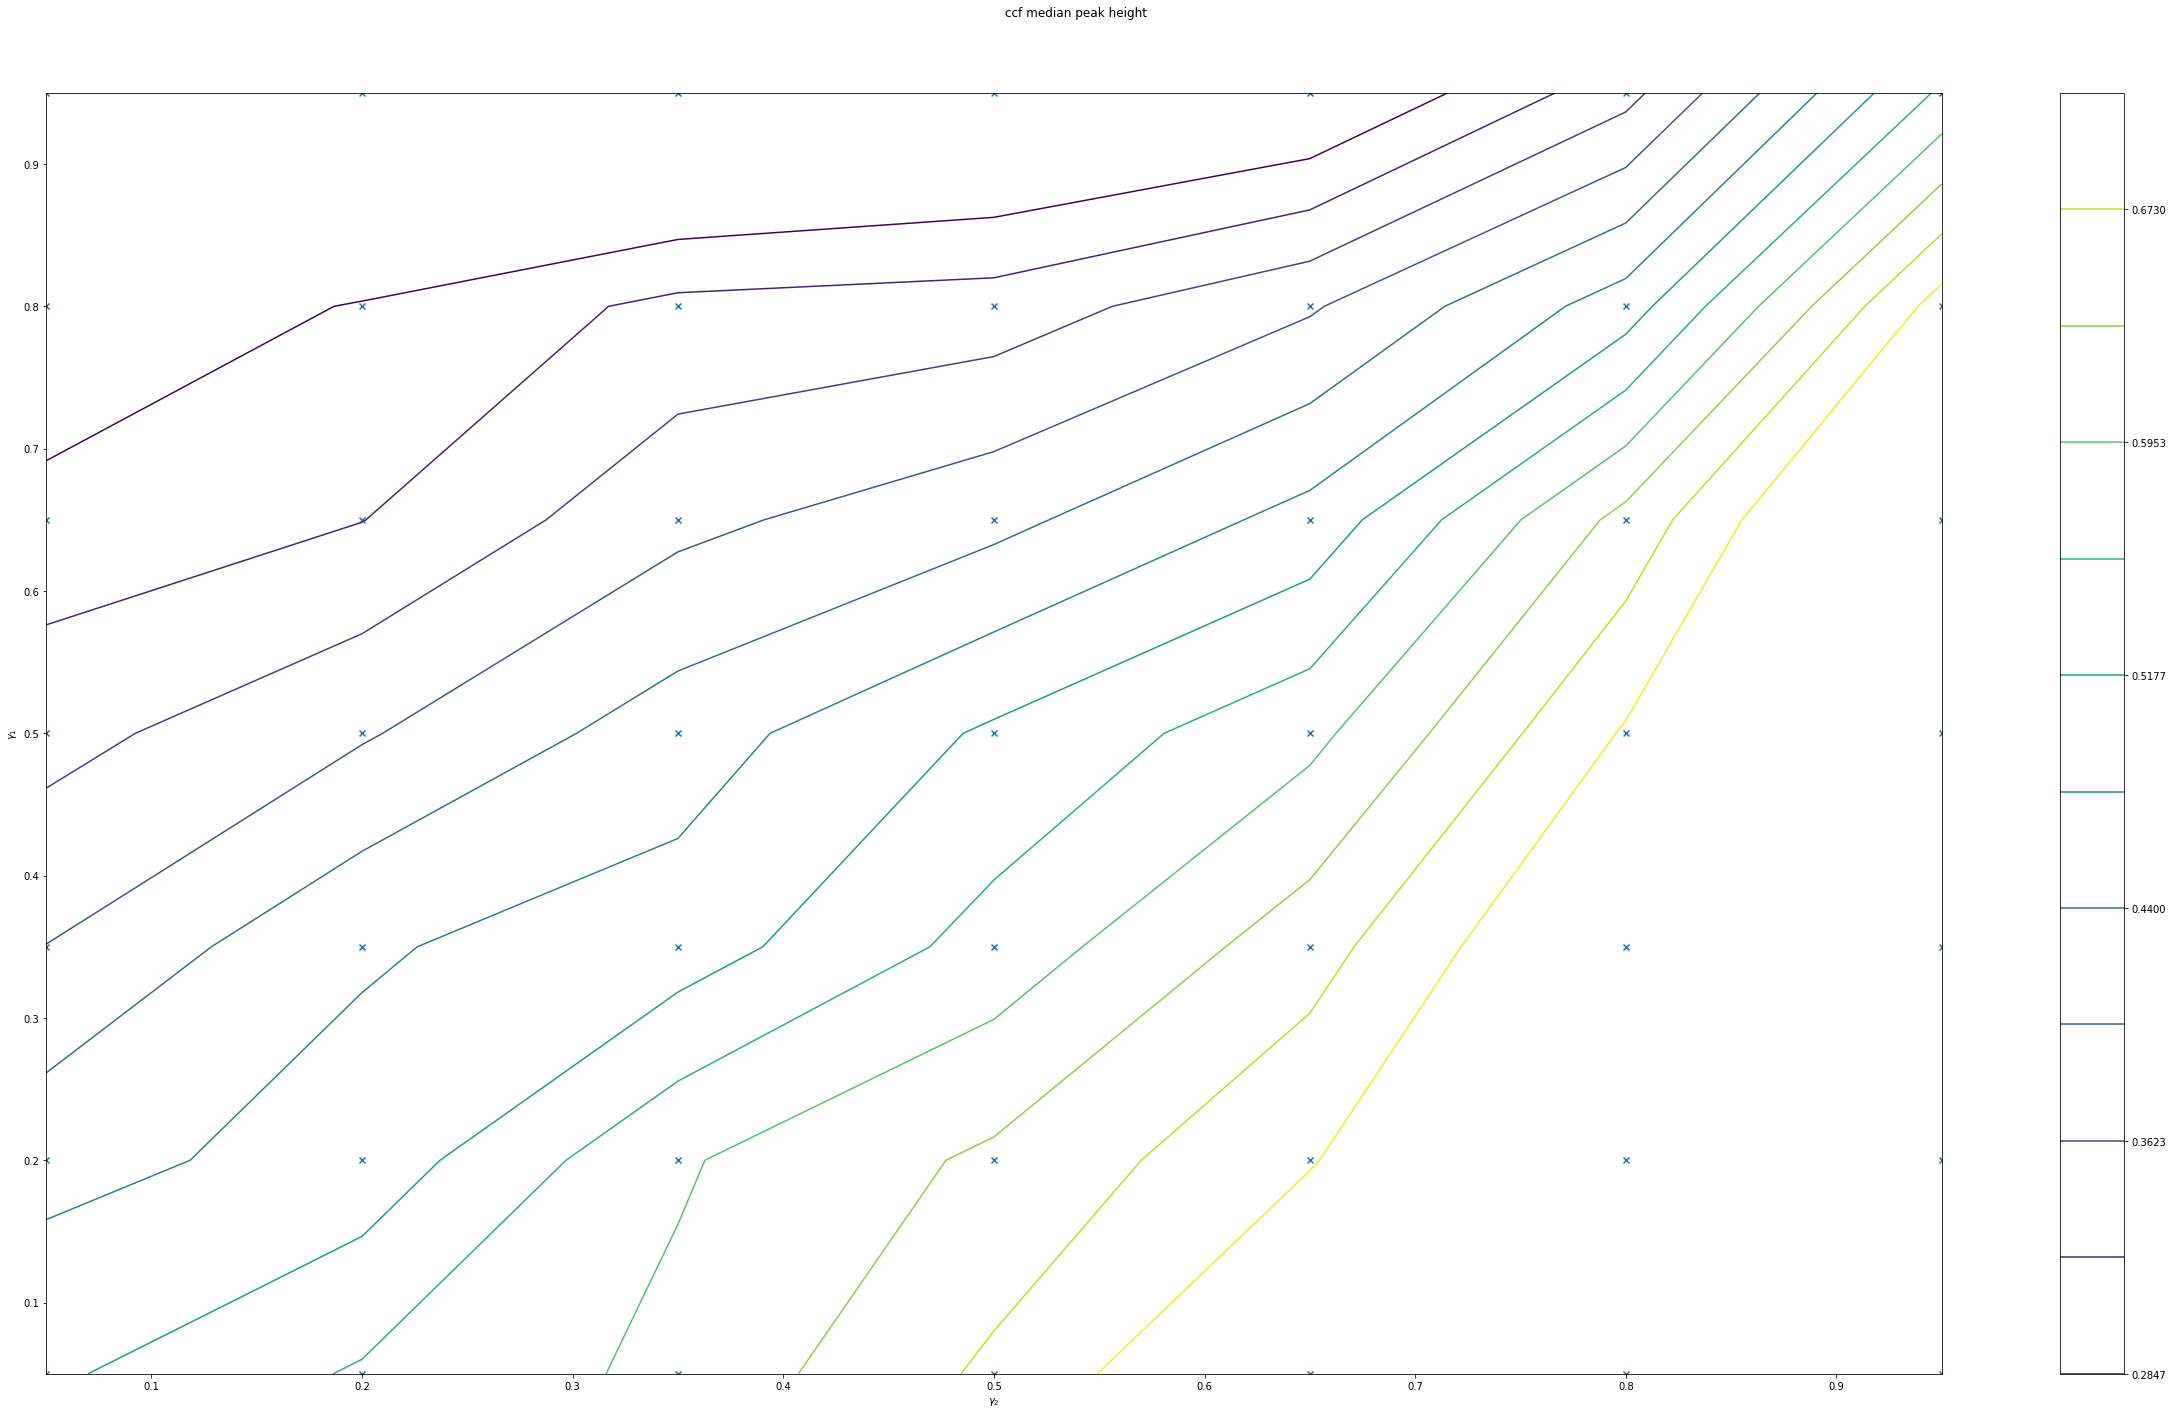

In [13]:
from plotting.plotting import plt_correlation
import numpy as np


plt_correlation(results, 
                steps_gamma1, 
                steps_gamma2, 
                yFn=lambda r: np.max(r['ccf_ensemble']['ccf_median']),
                get_x=lambda p: p['noiseType']['gamma1'],
                get_y=lambda p: p['noiseType']['gamma2'],
                noise_type=NoiseType.RED,
                ylabel = '$\\gamma_1$',
                xlabel= '$\\gamma_2$',
                title='ccf median peak height',
                hide_label=True,
                plt_red=False)

plt.tight_layout()
plt.subplots_adjust(None, None, 1.12, 0.92)
plt.savefig(img_path / 'ccf_peak_height.pdf', format='pdf')
# peak height

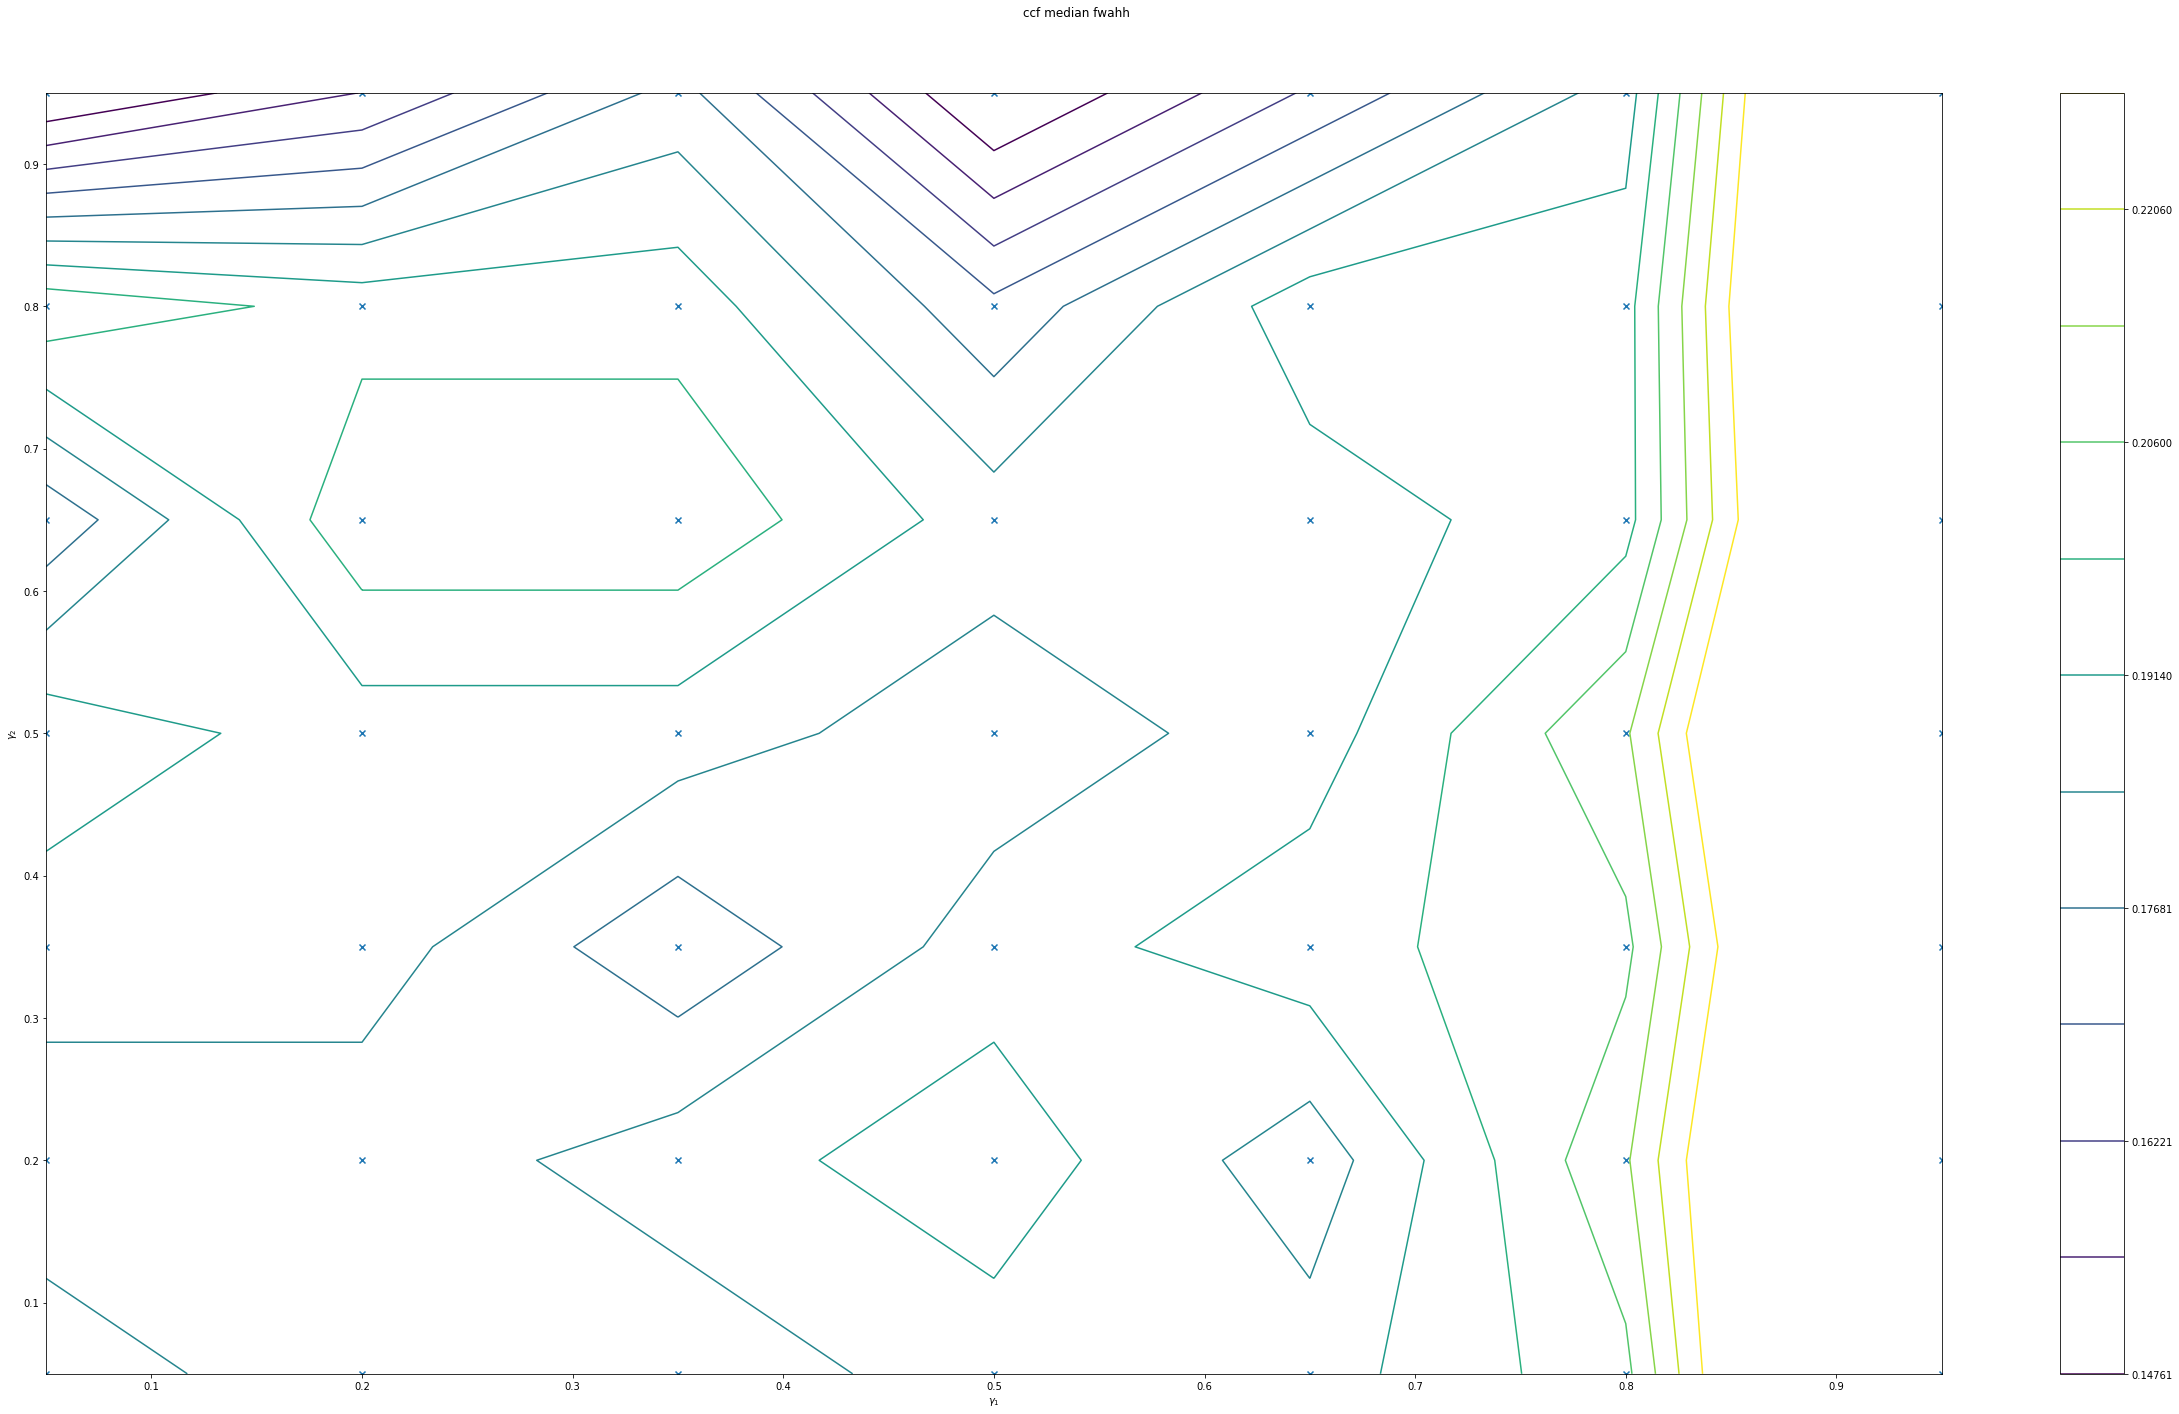

In [14]:
from plotting.plotting import plt_correlation
import numpy as np


plt_correlation(results, 
                steps_gamma1, 
                steps_gamma2, 
                yFn=lambda r: fwahh(r['ccf_ensemble']['ccf_median'])[2],
                get_x=lambda p: p['noiseType']['gamma1'],
                get_y=lambda p: p['noiseType']['gamma2'],
                noise_type=NoiseType.RED,
                ylabel = '$\\gamma_2$',
                xlabel= '$\\gamma_1$',
                title='ccf median fwahh',
                hide_label=True,
                plt_red=False)

plt.tight_layout()
plt.subplots_adjust(None, None, 1.12, 0.92)
plt.savefig(img_path / 'ccf_fwahh.pdf', format='pdf')
# peak height

# Full Width at half height debugging

49


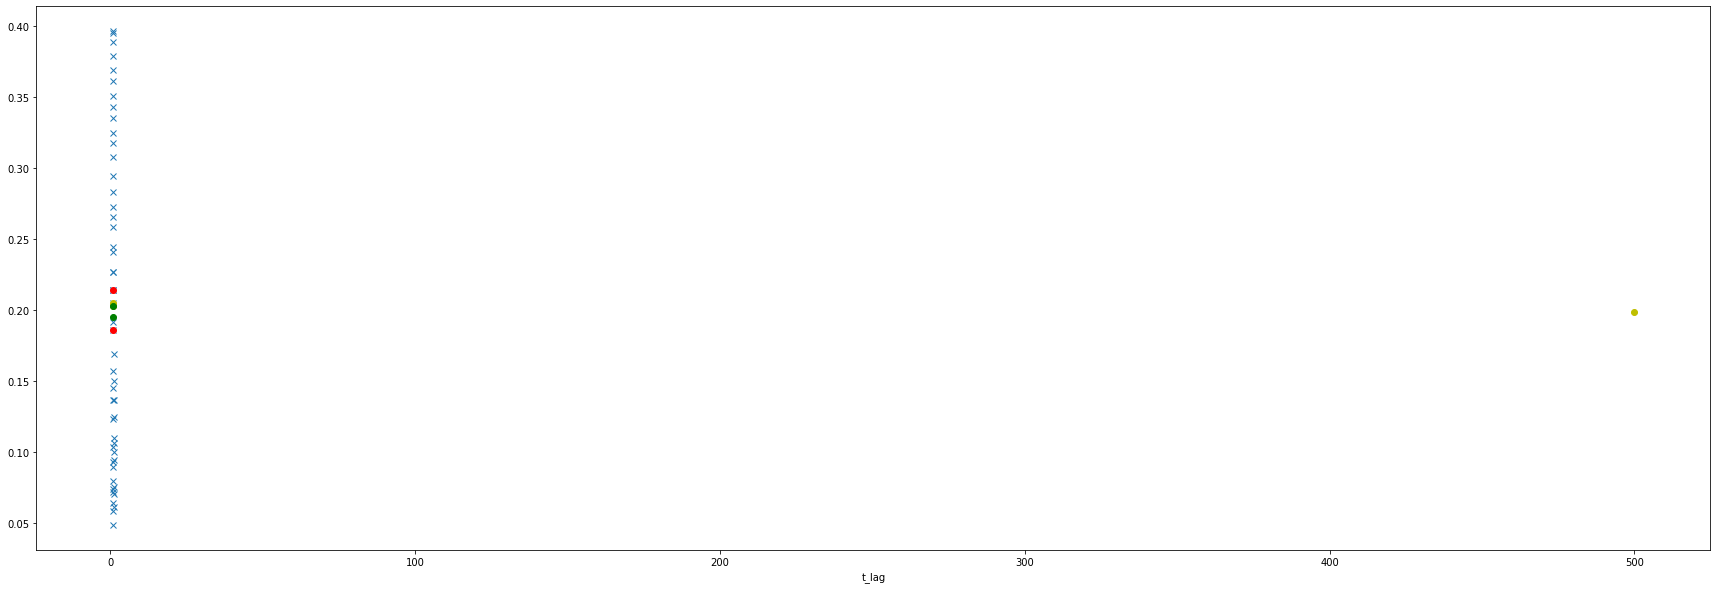

In [8]:
from plotting.plotting import fwahh
print(len(results))
median = results[10]['ccf_ensemble']['ccf_median']
ax = median.plot(style='x')

[i_l, i_r], [x_l, x_r], width, hh = fwahh(median)

h_l = median[i_l]
h_r = median[i_r]

i_l_i = (median.index[max(0, x_l + (-1 if h_l > h_r else 1))] + median.index[x_l]) / 2
i_r_i = (median.index[x_r + (-1 if h_l > h_r else 1)] + median.index[x_r]) / 2
h_l_i = (median.iloc[max(0, x_l + (-1 if h_l > h_r else 1))] + median.iloc[x_l]) / 2
h_r_i = (median.iloc[x_r + (-1 if h_l > h_r else 1)] + median.iloc[x_r]) / 2

# ax.plot(x_peak_index, height, 'ro')
height = (h_l + h_r) / 2
ax.plot([i_l_i, i_r_i], [(h_l_i + h_r_i) / 2, (h_l_i + h_r_i) / 2])
ax.plot(i_l_i, h_l_i, 'yo')

x_debug = x_r+(-1 if h_l > h_r else 1)
ax.plot(median.index[x_debug], median.iloc[x_debug], 'yo')
ax.plot(500, hh, 'yo')

ax.plot(i_l_i, h_l_i, 'go')
ax.plot(i_r_i, h_r_i, 'go')
ax.plot(i_l, median[i_l], 'ro')
ax.plot(i_r, median[i_r], 'ro')